In [113]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


This tutorial shows how to use an MMContext Sentence Transformers model. It assumes you created a huggingface dataset, which contains the cell representations (either cell ids for numerical embeddings or cell sentences for text_only usage). Such datasets can be created with a pipeline available through the https://github.com/mengerj/adata_hf_datasets repo. If you instead want to start from an adata object, see the tutorial evaluate_model_from_adata.ipynb

In [114]:
import pandas as pd
from datasets import load_dataset

repo_name = "jo-mengr"
dataset_name = "tabula_sapiens_50k_single_no_caption"
split_name = "test"
label_key = "cell_ontology_class"
batch_key = "batch_id"

In [115]:
dataset = load_dataset(f"{repo_name}/{dataset_name}")
test_dataset = dataset[split_name]

In [116]:
from sentence_transformers import SentenceTransformer

model_name = "jo-mengr/mmcontext-biobert-geneformer-v1-cxg_dim2048"
model = SentenceTransformer(model_name, trust_remote_code=True)
data_type = "geneformer-v1"
layer_key = f"X_{data_type}"
text_only = False
primary_cell_sentence = "cell_sentence_1"  # set to cell_sentence_2 for text based models

Loaded encoder was registered for 'geneformer-v1' data. Call register_initial_embeddings() with compatible data before using it.


In [119]:
from mmcontext.file_utils import load_test_adata_from_hf_dataset, subset_dataset_by_chunk

link_column = "share_link" if "share_link" in test_dataset.column_names else "adata_link"
adata, local_path = load_test_adata_from_hf_dataset(
    test_dataset, save_dir=f"../../data/from_nxtcloud/{dataset_name}", link_column=link_column
)
adata, dataset_sub = subset_dataset_by_chunk(adata, test_dataset)

Processing: 100%|██████████| 1/1 [01:19<00:00, 79.77s/file]
/Users/mengerj/repos/mmcontext/.venv/lib/python3.10/site-packages/anndata/_io/specs/registry.py:281: OldFormatWarning: Element '/obsm/X_geneformer' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=iospec)
/Users/mengerj/repos/mmcontext/.venv/lib/python3.10/site-packages/anndata/_io/specs/registry.py:281: OldFormatWarning: Element '/obsm/X_geneformer-v1' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=iospec)
/Users/mengerj/repos/mmcontext/.venv/lib/python3.10/site-packages/anndata/_io/specs/registry.py:281: OldFormatWarning: Element '/obsm/X_gs' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=iospec)
/Users/mengerj/repos/mmcontext/.venv/lib/python3.10/site-packages/anndata/_io/specs/registry.py:281: OldFormatWarning: Element '/obsm/X_gs10k' was written without encoding metadata.
  re

In [120]:
if not text_only:
    token_df, _ = model[0].get_initial_embeddings_from_adata_link(
        dataset_sub,
        layer_key=layer_key,
        download_dir=f"../../data/from_nxtcloud/{dataset_name}",
        axis="obs",
        link_column=link_column,
    )
    model[0].register_initial_embeddings(token_df, data_origin=data_type)

Processing: 100%|██████████| 1/1 [00:00<00:00, 5005.14file/s]
/Users/mengerj/repos/mmcontext/.venv/lib/python3.10/site-packages/anndata/_io/specs/registry.py:281: OldFormatWarning: Element '/obsm/X_geneformer' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=iospec)
/Users/mengerj/repos/mmcontext/.venv/lib/python3.10/site-packages/anndata/_io/specs/registry.py:281: OldFormatWarning: Element '/obsm/X_geneformer-v1' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=iospec)
/Users/mengerj/repos/mmcontext/.venv/lib/python3.10/site-packages/anndata/_io/specs/registry.py:281: OldFormatWarning: Element '/obsm/X_gs' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=iospec)
/Users/mengerj/repos/mmcontext/.venv/lib/python3.10/site-packages/anndata/_io/specs/registry.py:281: OldFormatWarning: Element '/obsm/X_gs10k' was written without encoding metadata.
  

Use the returned DataFrame to register the embeddings with `register_initial_embeddings()`.


In [121]:
from datasets import DatasetDict

from mmcontext.utils import truncate_cell_sentences

# enc.register_initial_embeddings(token_df, data_origin="geneformer")
if not text_only:
    dataset_ready = model[0].prefix_ds(dataset_sub, primary_cell_sentence)
else:
    dataset_split = truncate_cell_sentences(
        dataset_sub[split_name], primary_cell_sentence, max_length=64, filter_strings=["RPS", "RPL", "MT"]
    )
    dataset_ready = DatasetDict({split_name: dataset_split})

Prefixing columns: ['cell_sentence_1']: 100%|██████████| 26908/26908 [00:00<00:00, 28399.34 examples/s]


In [122]:
dataset_to_use = dataset_ready  # [split_name]

In [123]:
dataset_to_use[0]

{'sample_idx': 'TAACACGAGATTAGAC_TSP2_Lung_proxmedialdistal_10X_1_2',
 'cell_sentence_1': 'sample_idx:TAACACGAGATTAGAC_TSP2_Lung_proxmedialdistal_10X_1_2',
 'cell_sentence_2': 'PLXNA1 ATAD5 RPE ATAD2B NAV1 LINC02593 B3GALT6 FO704657.1 AL512383.1 CAMTA1-IT1 BX323043.1 AL357140.2 C1orf127 TMEM51-AS1 RPL22P3 AL137802.2 AL031432.3 AL606491.1 AL033528.2 AL512408.1 AL031729.1 RNU6ATAC27P EPB41 LINC01778 AC114488.2 AL136115.1 TMEM35B TEKT2 AL139220.2 LINC01144 CCDC163 RAD54L CYP4A22-AS1 AL050343.2 PLA2G12AP1 AL606760.3 LINC01771 GLIS1 NFIA-AS1 DLEU2L IL23R AC118549.1 COL24A1 AL445437.1 AC093423.2 HFM1 AL049796.1 TMEM56-RWDD3 AC092802.1 GPR88 GPR61 KCNA3 AL360270.2 KCND3 AL133517.1 FTH1P22 TRIM45 LINC01719 RF00003_ENSG00000274428.1 AC245100.4 LINC00869 RF00003_ENSG00000206828.1 HIST2H4A RF00015 AL162258.1 DCST2 GBA RHBG LRRC71 AL391001.1 AL451074.5 RN7SL269P TNN AL359265.3 LINC01686 AL390957.1 LINC01031 AL357793.1 SYT2 LINC01353 AC096533.1 CDCA4P4 AC092017.1 SNORA36B IBA57-DT AL121990.1 AL3575

In [124]:
text_encoder_name = model[0].text_encoder_name
text_encoder = SentenceTransformer(text_encoder_name)

No sentence-transformers model found with name dmis-lab/biobert-v1.1. Creating a new one with mean pooling.


In [125]:
modified_labels = [f"{label}" for label in adata.obs[label_key].values.tolist()]
# extend list by some aritifial labels
# modified_labels.extend(["human cell","neuron","apple","car"])
# get unique labels from the list
modified_labels = list(set(modified_labels))
modified_labels

['lung microvascular endothelial cell',
 'basophil',
 'respiratory goblet cell',
 'mast cell',
 'luminal epithelial cell of mammary gland',
 'cd4-positive helper t cell',
 'keratinocyte',
 'vascular associated smooth muscle cell',
 'naive b cell',
 'pancreatic beta cell',
 'smooth muscle cell',
 'limbal stem cell',
 'lacrimal gland functional unit cell',
 'cd8-positive, alpha-beta cytokine secreting effector t cell',
 'lung ciliated cell',
 'neutrophil',
 'fibroblast of cardiac tissue',
 'capillary endothelial cell',
 'intestinal crypt stem cell',
 'intestinal tuft cell',
 'nkt cell',
 'melanocyte',
 'cardiac muscle cell',
 'cd8-positive, alpha-beta t cell',
 'platelet',
 'cd8-positive, alpha-beta memory t cell',
 'bronchial smooth muscle cell',
 'cd24 neutrophil',
 'mesenchymal stem cell',
 'cd4-positive, alpha-beta t cell',
 'type ii pneumocyte',
 'immature natural killer cell',
 'luminal cell of prostate epithelium',
 'paneth cell of epithelium of large intestine',
 'epithelial cell

In [128]:
omics_embeddings = model.encode(dataset_to_use[primary_cell_sentence])
label_embeddings = model.encode(modified_labels)
adata.obsm["mmcontext_emb"] = omics_embeddings
# adata.obsm["mmcontext_text_emb"] = text_embeddings
# adata.obsm["og_text_emb"] = text_encoder.encode(adata.obs[label_key].values.tolist())
# adata.obsm["og_text_omics_emb"] = text_encoder.encode(dataset_to_use[primary_cell_sentence])

In [62]:
# adata.obsm["og_description_emb"] = text_encoder.encode(adata.obs["natural_language_annotation"])

In [63]:
# adata.obsm["mmcontext_description_emb"] = model.encode(adata.obs["natural_language_annotation"])

In [64]:
# adata.obs[batch_key] = adata.obs[batch_key].astype("category")
# make Nans to "other" in batch
# adata.obs[batch_key] = adata.obs[batch_key].cat.add_categories("other")
# adata.obs[batch_key].fillna("other", inplace=True)

<Figure size 800x800 with 0 Axes>

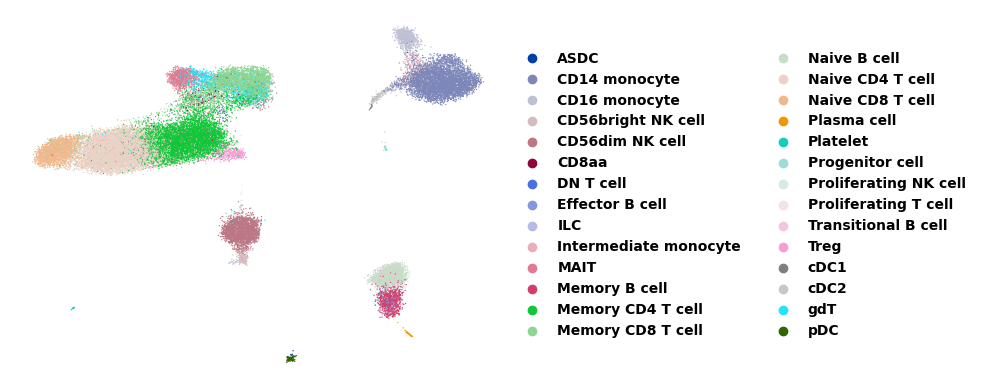

In [109]:
# Visualise the embeddings
from mmcontext.pl import plot_umap
from mmcontext.utils import consolidate_low_frequency_categories

current_key = label_key
adata_cut = consolidate_low_frequency_categories(adata, [current_key], threshold=1, remove=False)
emb_key = "mmcontext_emb"
plot_umap(
    adata,
    color_key=label_key,
    embedding_key=emb_key,
    save_format="svg",
    save_dir=f"figs/{model_name}/{dataset_name}",
    save_plot=False,
    title="",
)

In [67]:
# Visualise the embeddings
# from mmcontext.pl import plot_umap
# from mmcontext.utils import consolidate_low_frequency_categories

# current_key = label_key
# adata_cut = consolidate_low_frequency_categories(adata, [current_key], threshold=1, remove = False)
# emb_key = layer_key
# plot_umap(
#    adata_cut,
#    color_key=label_key,
#    embedding_key=emb_key,
#    save_format="svg",
#    nametag="",
#    save_dir=f"figs/{model_name}/{dataset_name}",
#    save_plot=False,
#    title="",
# )

In [126]:
from mmcontext.eval import get

EvClass = get("LabelSimilarity")
ev = EvClass(
    auto_filter_labels=False,
    umap_n_neighbors=15,
    umap_min_dist=0.5,
    similarity="cosine",
    logit_scale=1,
    score_norm_method=None,
)

In [129]:
from pathlib import Path

result = ev.compute(
    omics_embeddings=adata.obsm["mmcontext_emb"],
    label_embeddings=label_embeddings,
    query_labels=modified_labels,
    true_labels=adata.obs[label_key],
    label_key=label_key,
    out_dir=Path(f"LabelSimilarity/{model_name}/{dataset_name}"),  # Pass output directory for caching
)

/Users/mengerj/repos/mmcontext/src/mmcontext/eval/label_similarity.py:76: RuntimeWarning: divide by zero encountered in matmul
  return (emb1_norm @ emb2_norm.T).astype(np.float32)
/Users/mengerj/repos/mmcontext/src/mmcontext/eval/label_similarity.py:76: RuntimeWarning: overflow encountered in matmul
  return (emb1_norm @ emb2_norm.T).astype(np.float32)
/Users/mengerj/repos/mmcontext/src/mmcontext/eval/label_similarity.py:76: RuntimeWarning: invalid value encountered in matmul
  return (emb1_norm @ emb2_norm.T).astype(np.float32)


In [130]:
result

acinar cell of salivary gland/auc: 0.8321
acinar cell of salivary gland/accuracy: 0.0000
adventitial cell/auc: 0.5231
adventitial cell/accuracy: 0.0000
alveolar fibroblast/auc: 0.9426
alveolar fibroblast/accuracy: 0.5500
artery endothelial cell/auc: 0.9311
artery endothelial cell/accuracy: 0.0000
b cell/auc: 0.7803
b cell/accuracy: 0.0000
basal cell/auc: 0.6198
basal cell/accuracy: 0.0210
basal cell of prostate epithelium/auc: 0.8209
basal cell of prostate epithelium/accuracy: 0.0000
basophil/auc: 0.8466
basophil/accuracy: 0.4200
bladder urothelial cell/auc: 0.8064
bladder urothelial cell/accuracy: 0.0000
bronchial smooth muscle cell/auc: 0.9793
bronchial smooth muscle cell/accuracy: 0.5000
bronchial vessel endothelial cell/auc: 0.5889
bronchial vessel endothelial cell/accuracy: 0.0000
capillary aerocyte/auc: 0.9610
capillary aerocyte/accuracy: 0.0000
capillary endothelial cell/auc: 0.9797
capillary endothelial cell/accuracy: 0.0566
cardiac endothelial cell/auc: 0.9644
cardiac endothel

In [71]:
ev.plot(
    omics_embeddings=adata.obsm["mmcontext_emb"],
    out_dir=Path(f"LabelSimilarity/{model_name}/{dataset_name}/{label_key}"),
    label_embeddings=label_embeddings,
    query_labels=modified_labels,
    true_labels=adata.obs[label_key],
    label_key=label_key,  # column name (e.g. "celltype")
    save_format="png",
    figsize=(4, 4),
    dpi=600,
    font_size=12,
    font_style="normal",
    font_weight="normal",
    legend_fontsize=54,
    axis_label_size=20,
    axis_tick_size=12,
    point_size=0.5,
    legend_layout="vertical",
    legend_point_size=20,
    text_dot_fill_color="black",
    text_dot_edge_color="label",
    text_dot_alpha=0.2,
    umap_method="separate",
)

/Users/mengerj/repos/mmcontext/src/mmcontext/eval/label_similarity.py:76: RuntimeWarning: divide by zero encountered in matmul
  return (emb1_norm @ emb2_norm.T).astype(np.float32)
/Users/mengerj/repos/mmcontext/src/mmcontext/eval/label_similarity.py:76: RuntimeWarning: overflow encountered in matmul
  return (emb1_norm @ emb2_norm.T).astype(np.float32)
/Users/mengerj/repos/mmcontext/src/mmcontext/eval/label_similarity.py:76: RuntimeWarning: invalid value encountered in matmul
  return (emb1_norm @ emb2_norm.T).astype(np.float32)
/Users/mengerj/repos/mmcontext/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/mengerj/repos/mmcontext/src/mmcontext/eval/label_similarity.py:76: RuntimeWarning: divide by zero encountered in matmul
  return (emb1_norm @ emb2_norm.T).astype(np.float32)
/Users/mengerj/repos/mmcontext/src/mmcontext/eval/label_similarity.py:76: RuntimeWarning: o

In [331]:
# Option to subset adata based on one or more label values (e.g., "Monocyte" and "DC")
subset_label_values = ["T cell"]  # Change this list to your desired label values
subset_label_key = "AIFI_L1"
# Subset the AnnData object for any of the specified label values
adata_subset = adata[adata.obs[subset_label_key].isin(subset_label_values)].copy()
subset_labels = adata_subset.obs[label_key].values.unique()
label_embeddings_subset = model.encode(subset_labels)
# Create a new LabelSimilarity evaluator instance
ev_subset = EvClass(auto_filter_labels=False, umap_n_neighbors=15, umap_min_dist=0.5)
subset_label_string = "_".join(subset_label_values)
ev_subset.eb_lfdr_q = 0.01
# Compute metrics on the subsetted data
result_subset = ev_subset.compute(
    omics_embeddings=adata_subset.obsm["mmcontext_emb"],
    label_embeddings=label_embeddings_subset,
    query_labels=subset_labels,
    true_labels=adata_subset.obs[label_key],
    label_key=label_key,
    out_dir=Path(f"LabelSimilarity/{model_name}/{dataset_name}/{label_key}_subset_{subset_label_string}/results"),
)

# Plot results for the subset
ev_subset.plot(
    omics_embeddings=adata_subset.obsm["mmcontext_emb"],
    out_dir=Path(f"LabelSimilarity/{model_name}/{dataset_name}/{label_key}_subset_{subset_label_string}"),
    label_embeddings=label_embeddings_subset,
    query_labels=subset_labels,
    true_labels=adata_subset.obs[label_key],
    label_key=label_key,
    save_format="png",
    figsize=(4, 4),
    dpi=600,
    font_size=12,
    axis_tick_size=12,
    font_style="normal",
    font_weight="normal",
    legend_fontsize=54,
    axis_label_size=20,
    point_size=0.5,
    legend_layout="vertical",
    legend_point_size=20,
    text_dot_fill_color="black",
    text_dot_edge_color="label",
    text_dot_alpha=0.4,
    umap_method="separate",
)

/Users/mengerj/repos/mmcontext/src/mmcontext/eval/label_similarity.py:76: RuntimeWarning: divide by zero encountered in matmul
  return (emb1_norm @ emb2_norm.T).astype(np.float32)
/Users/mengerj/repos/mmcontext/src/mmcontext/eval/label_similarity.py:76: RuntimeWarning: overflow encountered in matmul
  return (emb1_norm @ emb2_norm.T).astype(np.float32)
/Users/mengerj/repos/mmcontext/src/mmcontext/eval/label_similarity.py:76: RuntimeWarning: invalid value encountered in matmul
  return (emb1_norm @ emb2_norm.T).astype(np.float32)
/Users/mengerj/repos/mmcontext/src/mmcontext/eval/label_similarity.py:76: RuntimeWarning: divide by zero encountered in matmul
  return (emb1_norm @ emb2_norm.T).astype(np.float32)
/Users/mengerj/repos/mmcontext/src/mmcontext/eval/label_similarity.py:76: RuntimeWarning: overflow encountered in matmul
  return (emb1_norm @ emb2_norm.T).astype(np.float32)
/Users/mengerj/repos/mmcontext/src/mmcontext/eval/label_similarity.py:76: RuntimeWarning: invalid value enco

In [ ]:
from mmcontext.eval.query_annotate import OmicsQueryAnnotator

annotator = OmicsQueryAnnotator(model)
annotator.annotate_omics_data(adata, modified_labels, emb_key="mmcontext_emb")

/Users/mengerj/repos/mmcontext/src/mmcontext/eval/query_annotate.py:112: RuntimeWarning: divide by zero encountered in matmul
  similarity_matrix = data_emb @ label_emb.T
/Users/mengerj/repos/mmcontext/src/mmcontext/eval/query_annotate.py:112: RuntimeWarning: overflow encountered in matmul
  similarity_matrix = data_emb @ label_emb.T
/Users/mengerj/repos/mmcontext/src/mmcontext/eval/query_annotate.py:112: RuntimeWarning: invalid value encountered in matmul
  similarity_matrix = data_emb @ label_emb.T


In [163]:
# get accuracy of best label vs true label
from sklearn.metrics import accuracy_score

accuracy_score(adata.obs["best_label"], adata.obs[label_key])

0.42632695122315484

In [159]:
if dataset_name == "human_immune_health_atlas_50k_single_no_caption":
    df = pd.read_csv("../../data/queries/additional_combined.csv")
    labels = df["Cell Type"]
    Definition = df["Definition"]
    from mmcontext.eval.query_annotate import OmicsQueryAnnotator
    from mmcontext.pl.plotting import plot_query_scores_with_labels_umap

    annotator = OmicsQueryAnnotator(model)
    annotator.query_with_text(adata, Definition, emb_key="mmcontext_emb")
    # Call the plotting function
    plot_query_scores_with_labels_umap(
        adata=adata,
        queries=Definition,
        labels=labels,
        label_key="AIFI_L2",
        save_dir=f"figs/{model_name}/{dataset_name}/umap_with_labels",
        nametag="",
        figsize=(4, 4),
        point_size=2,
        dpi=300,  # Lower DPI for faster generation
        axis_label_size=18,
        axis_tick_size=18,
    )

/Users/mengerj/repos/mmcontext/src/mmcontext/eval/query_annotate.py:179: RuntimeWarning: divide by zero encountered in matmul
  similarity_matrix = query_emb @ data_emb.T
/Users/mengerj/repos/mmcontext/src/mmcontext/eval/query_annotate.py:179: RuntimeWarning: overflow encountered in matmul
  similarity_matrix = query_emb @ data_emb.T
/Users/mengerj/repos/mmcontext/src/mmcontext/eval/query_annotate.py:179: RuntimeWarning: invalid value encountered in matmul
  similarity_matrix = query_emb @ data_emb.T
/Users/mengerj/repos/mmcontext/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [79]:
from mmcontext.eval.utils import create_emb_pair_dataframe

emb_pair_df = create_emb_pair_dataframe(
    adata,
    embedding_dict={"omics": "mmcontext_emb", "text": "mmcontext_text_emb"},
    subset_size=20,
    label_keys=[batch_key, label_key],
)

/Users/mengerj/repos/mmcontext/src/mmcontext/eval/utils.py:208: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row[label_key] = adata.obs[label_key][sampled_indices[idx]]


Requested n_samples (50) is greater than total unique sample_ids (20). Using all sample_ids instead.
/Users/mengerj/repos/mmcontext/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


<Figure size 6000x6000 with 0 Axes>

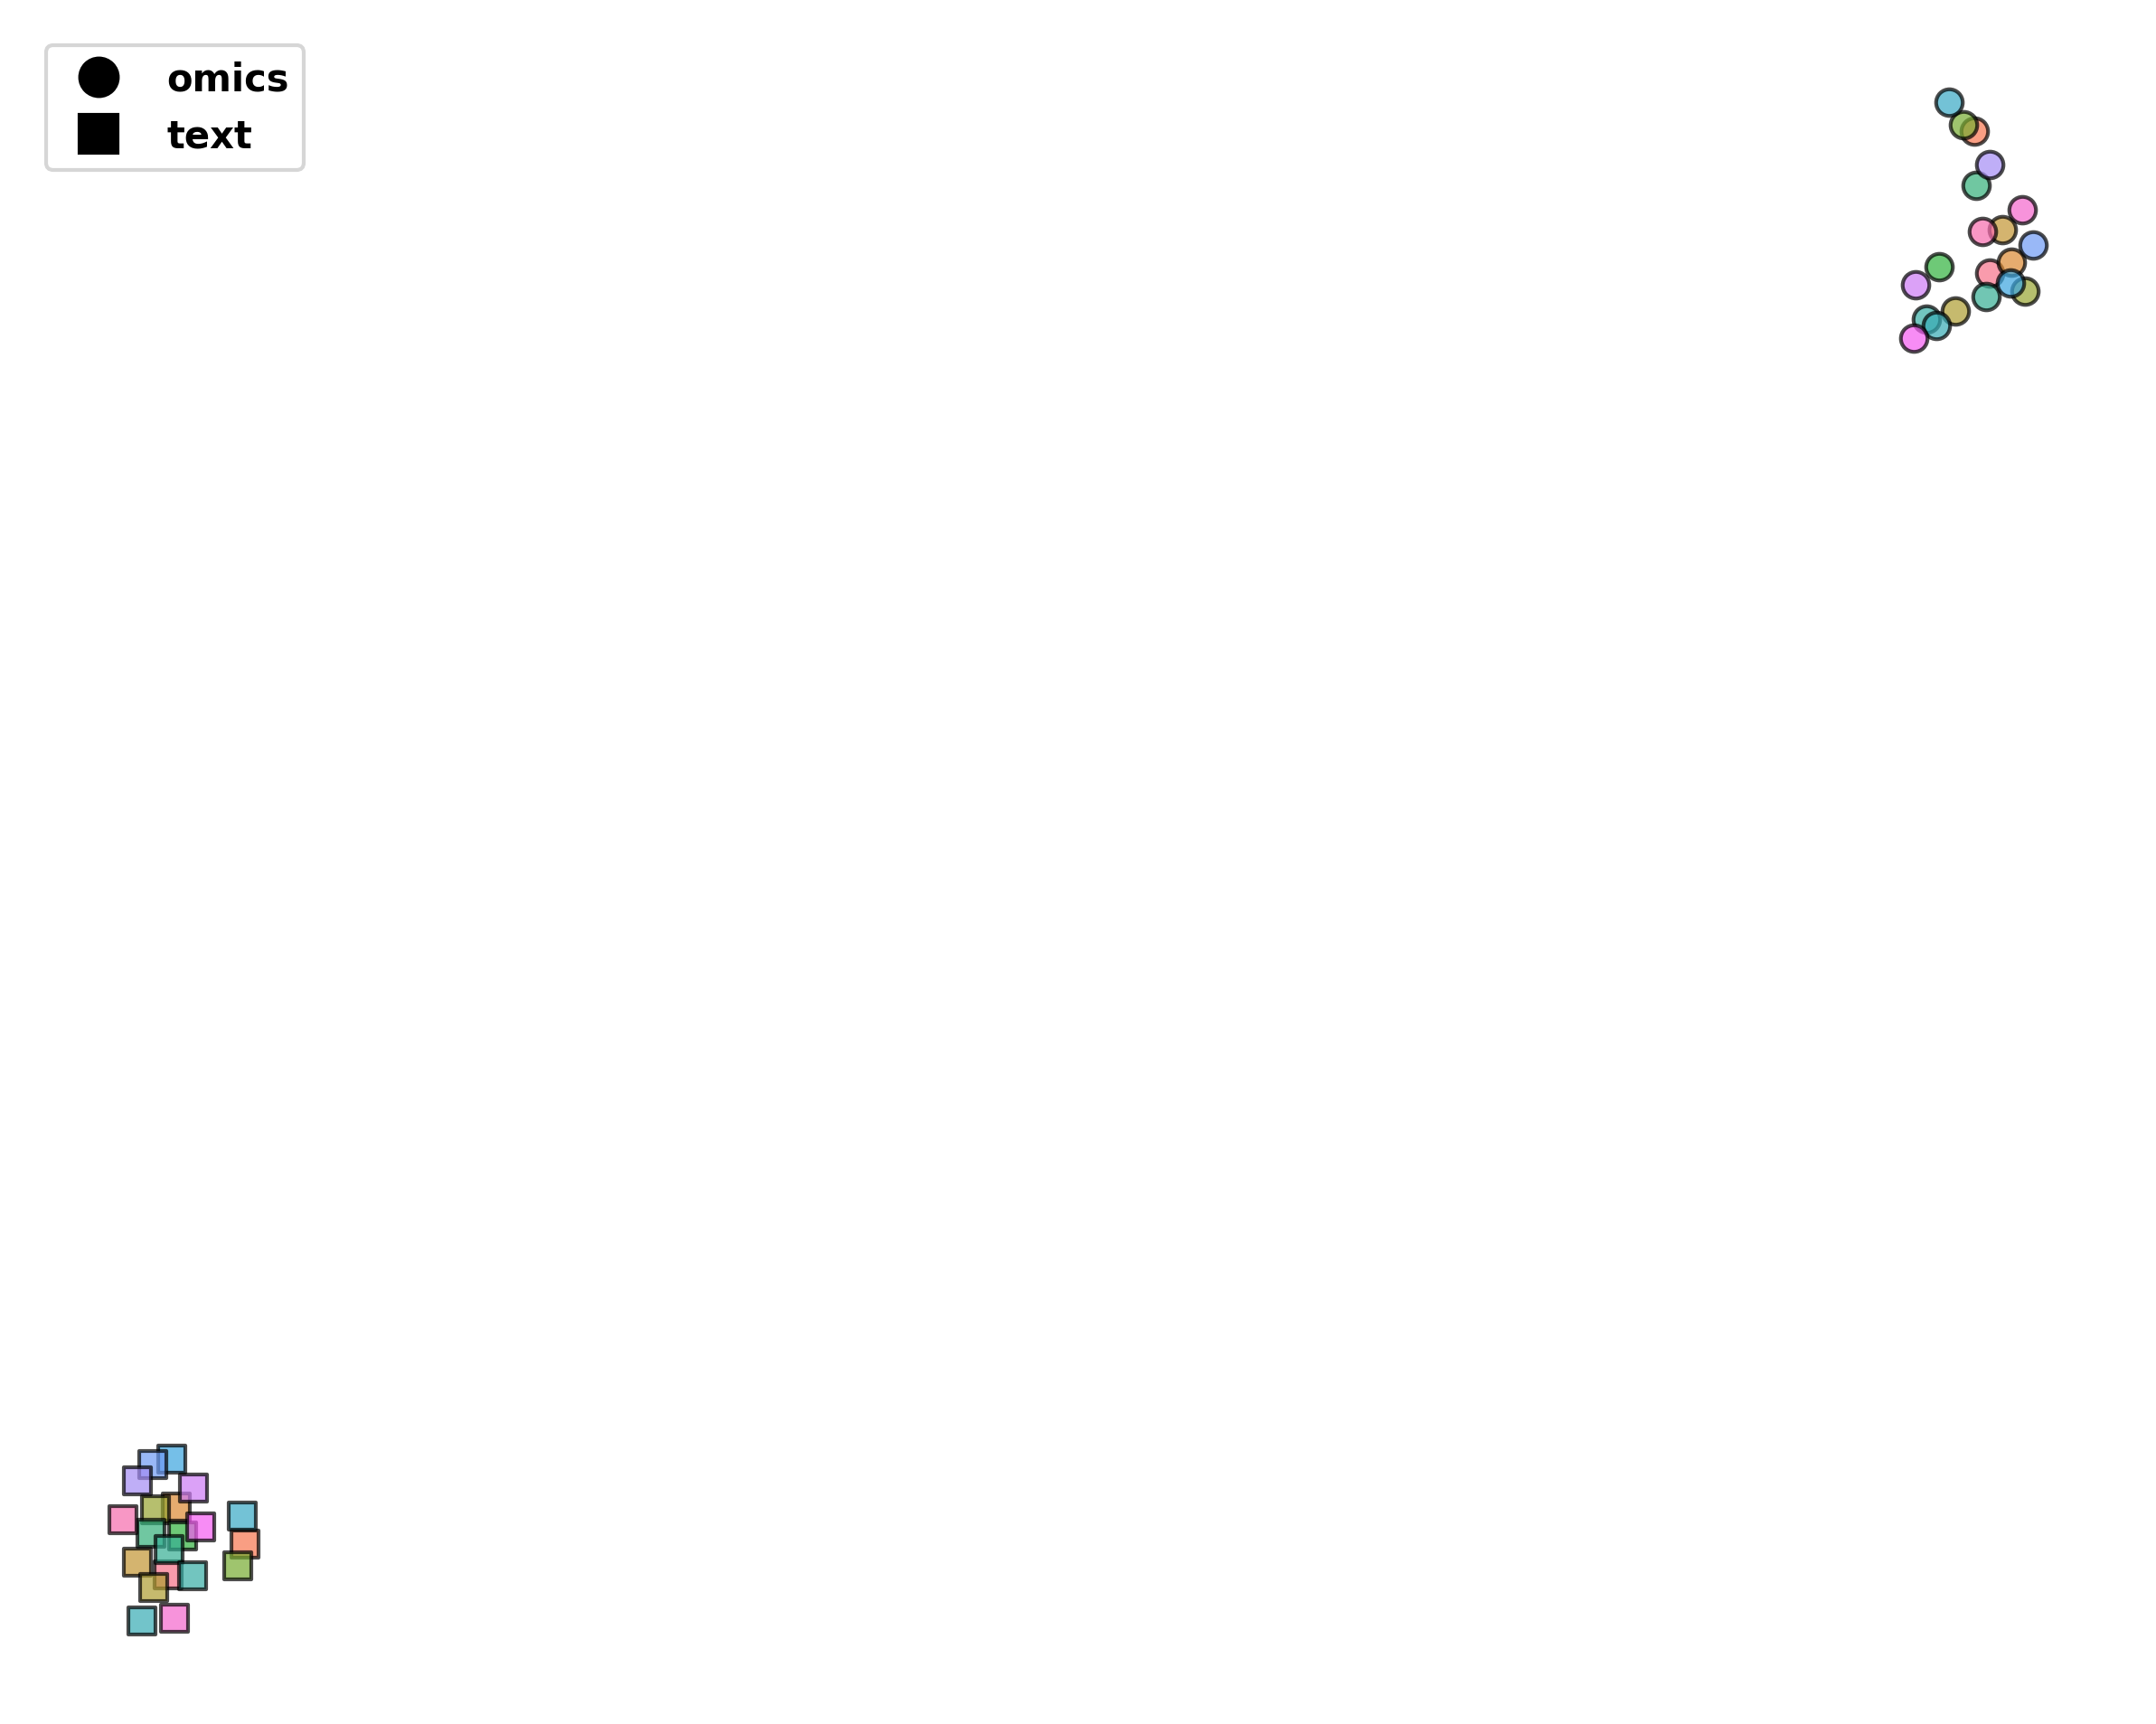

In [58]:
from mmcontext.pl import visualize_embedding_clusters

visualize_embedding_clusters(emb_pair_df, method="umap", metric="cosine", n_neighbors=15, min_dist=0.1, random_state=42)

/Users/mengerj/repos/mmcontext/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/mengerj/repos/mmcontext/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/mengerj/repos/mmcontext/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


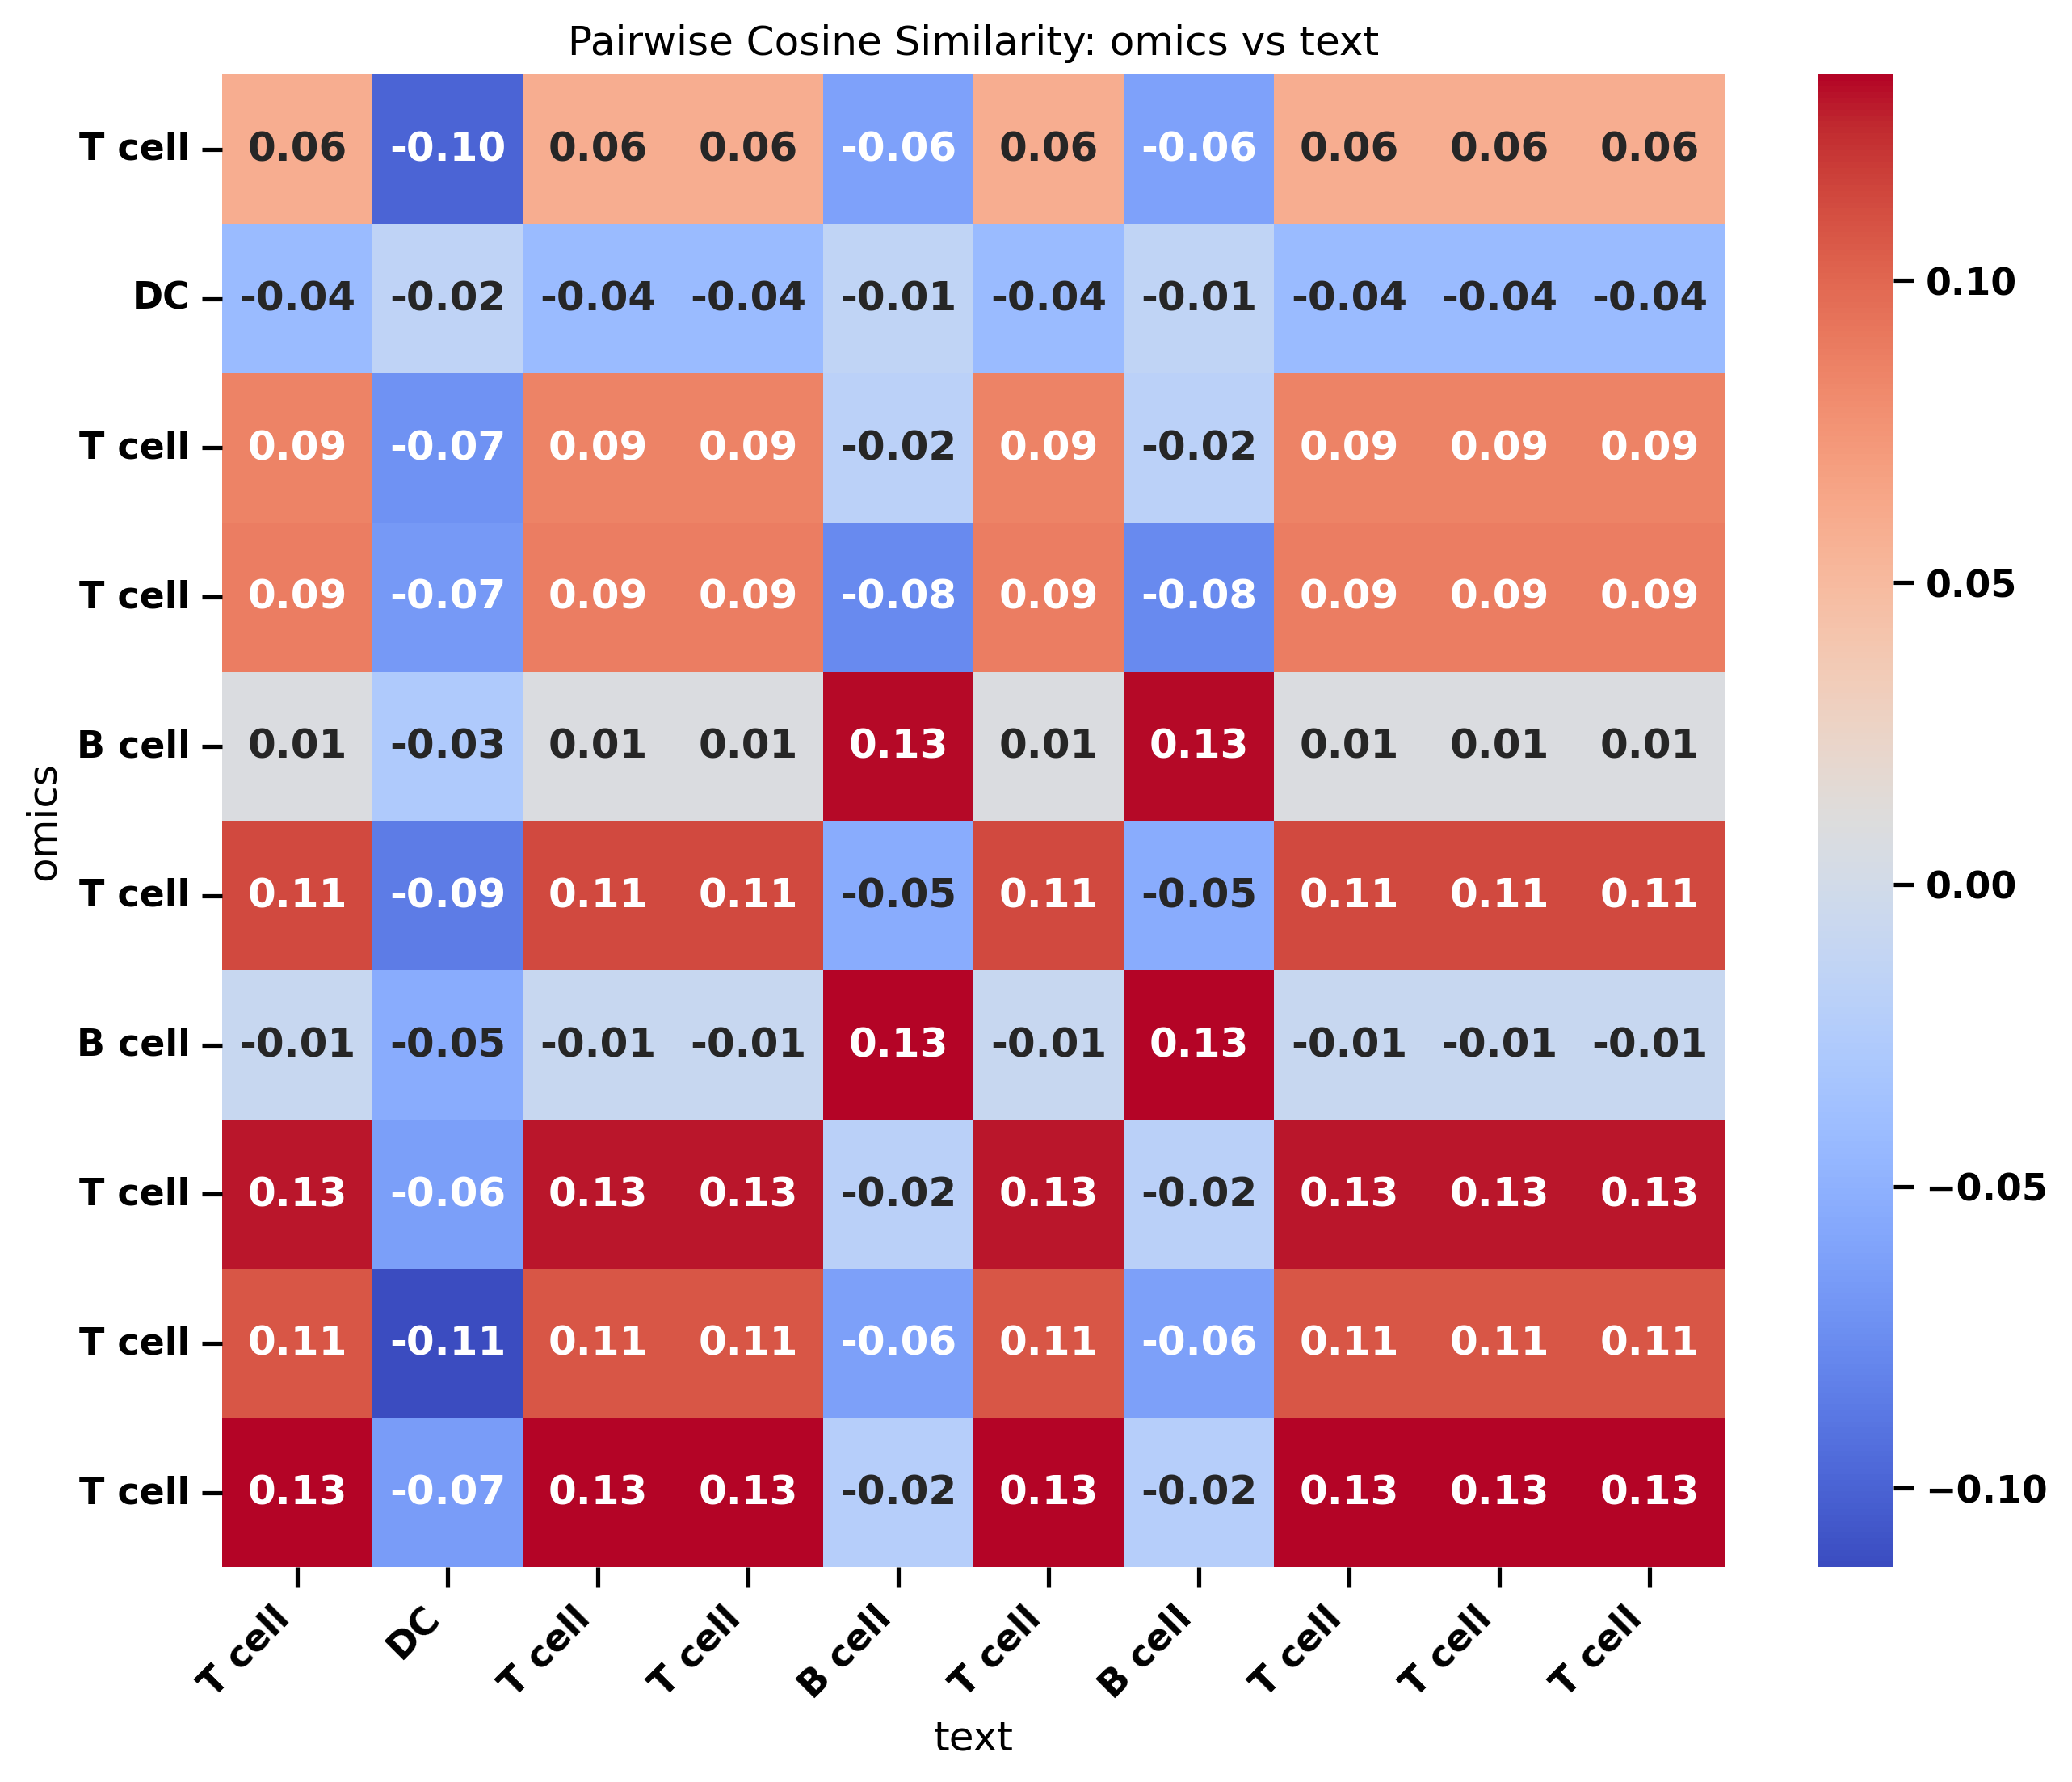

In [59]:
from mmcontext.pl.plotting import plot_embedding_similarity

plot_embedding_similarity(emb_pair_df, emb1_type="omics", emb2_type="text", label_key=label_key)

/Users/mengerj/repos/mmcontext/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/mengerj/repos/mmcontext/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/mengerj/repos/mmcontext/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


<Figure size 3000x2400 with 0 Axes>

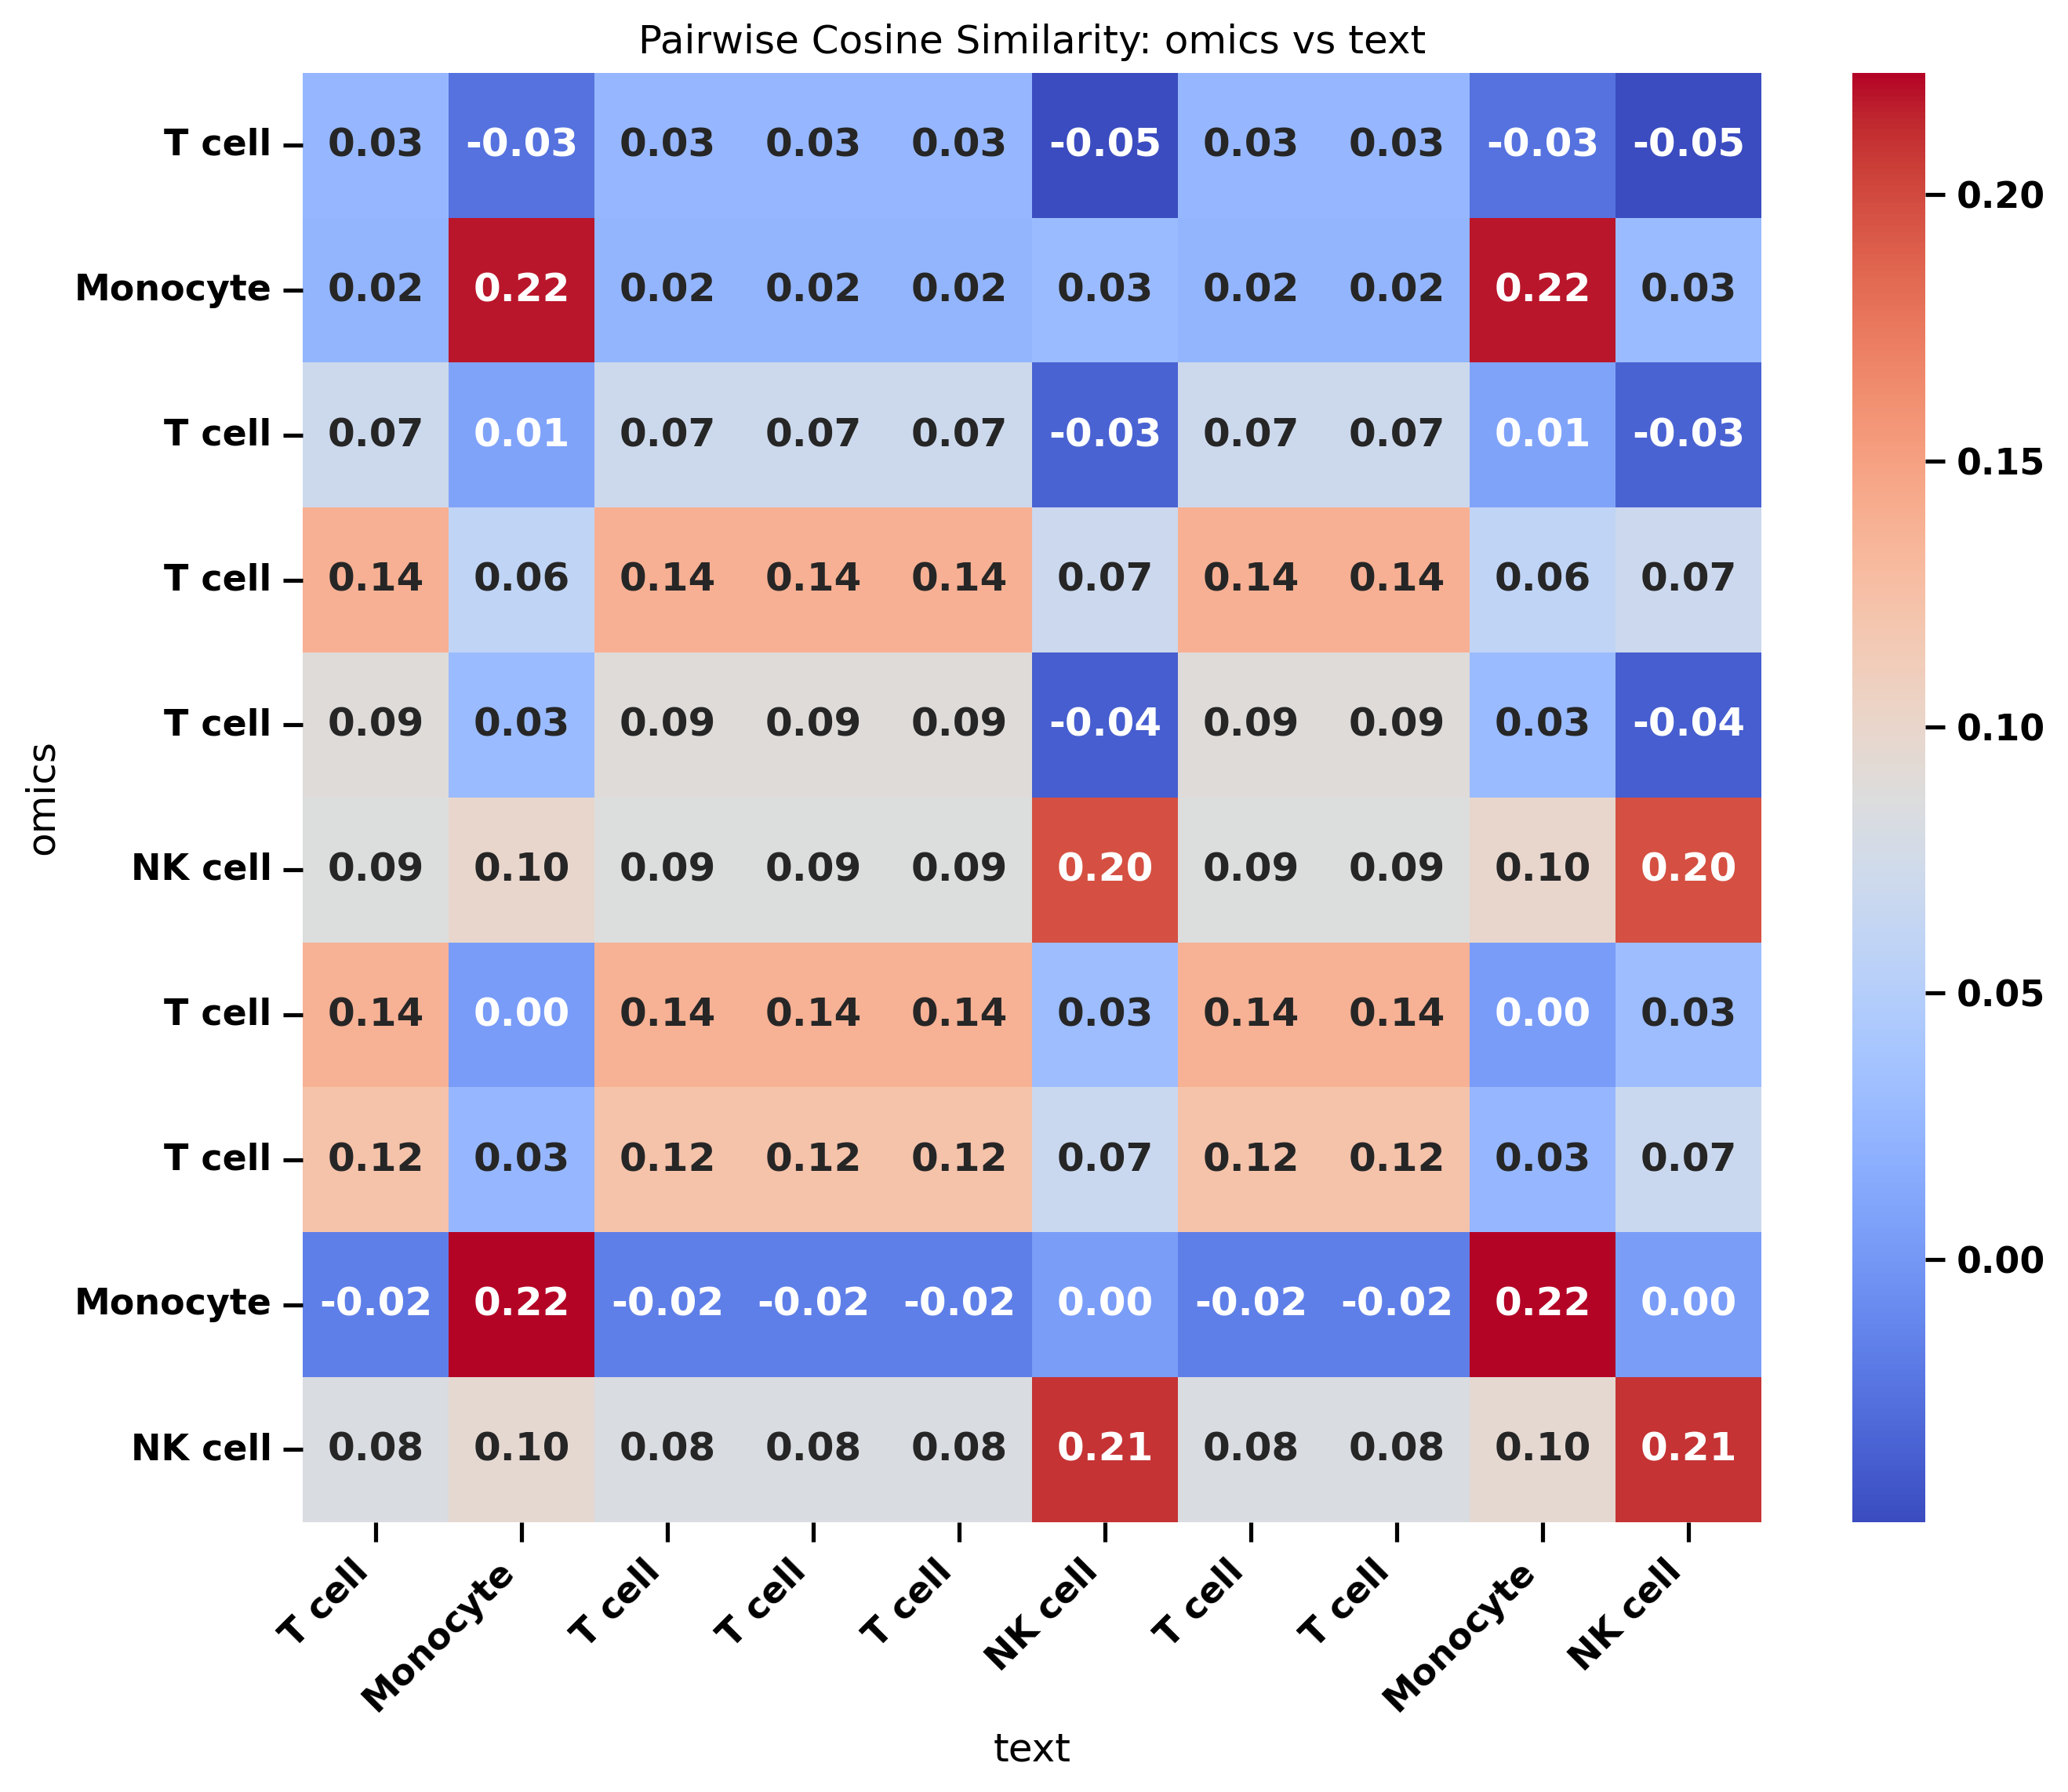

In [154]:
from mmcontext.pl.plotting import plot_embedding_similarity

plot_embedding_similarity(emb_pair_df, emb1_type="omics", emb2_type="text", label_key=label_key)

/Users/mengerj/repos/mmcontext/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/mengerj/repos/mmcontext/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/mengerj/repos/mmcontext/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


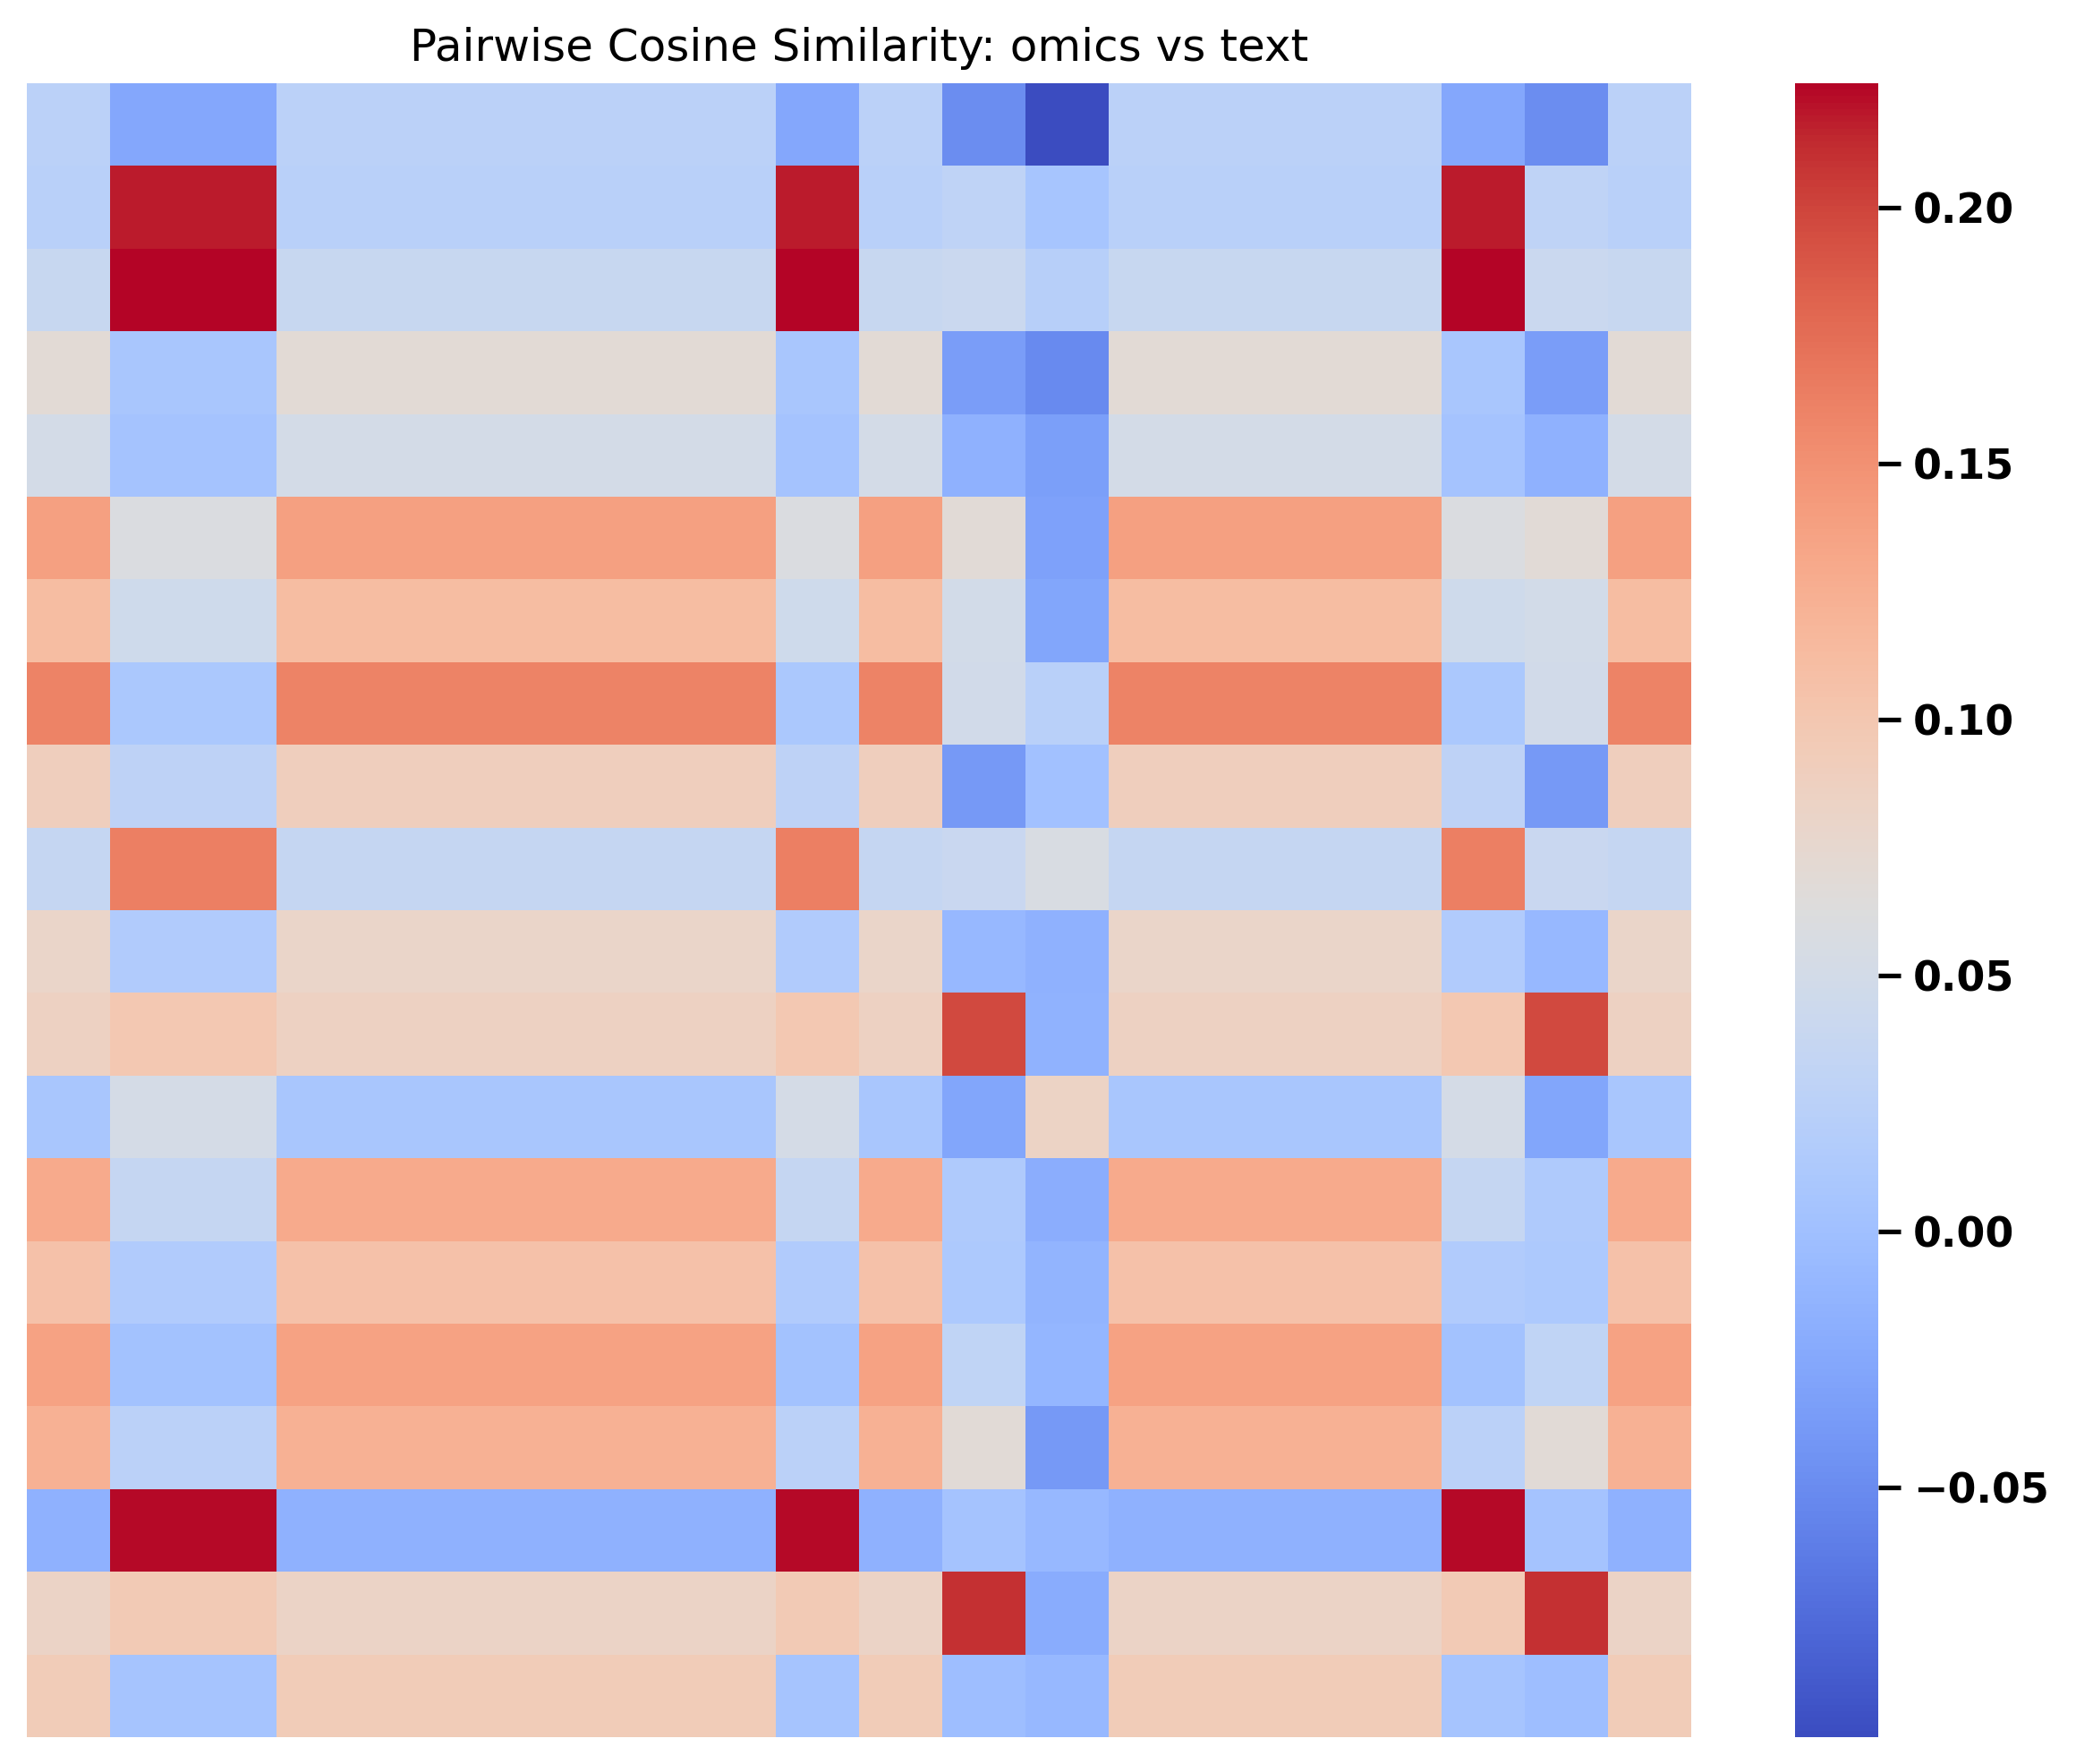

In [158]:
from mmcontext.pl.plotting import plot_embedding_similarity

plot_embedding_similarity(emb_pair_df, emb1_type="omics", emb2_type="text", n_samples=100)

In [1]:
from mmcontext.pp import remove_zero_variance_cells, remove_zero_variance_genes

adata = remove_zero_variance_cells(adata)
adata = remove_zero_variance_genes(adata)

/Users/mengerj/repos/mmcontext/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NameError: name 'adata' is not defined

In [42]:
from mmcontext.eval import scibEvaluator

evalutator = scibEvaluator(
    adata=adata,
    batch_key="batch",
    label_key="cluster_lavel",
    embedding_key=["mmcontext_emb", "mmcontext_text_emb", "X_geneformer", "X_hvg", "X_pca", "X_scvi"],
    n_top_genes=5000,
    max_cells=5000,
)
res = evalutator.evaluate()

HVG


Error in data reduction: Bin edges must be unique: Index([               -inf,  -2.892823703725029, -0.6085385346302277,
       0.09924078048896734, 0.09924078048896734, 0.09924079373444396,
       0.14027225325936107, 0.18885910880786402, 0.23705809401106778,
          0.30732003013017,  0.4241397468442167,   0.611900446591554,
        0.9100024470921467,  1.3157359159517066,  1.9957290970961805,
         2.822801220996513,   3.787105232711744,    5.15218205363662,
         7.423641985710012,  100.20904103227615,                 inf],
      dtype='float64').
You can drop duplicate edges by setting the 'duplicates' kwarg
Using full data for metrics computation.


HVG
Cluster for cluster_0.2 with leiden


KeyError: 'No "neighbors" in .uns'